In [34]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from keras.layers import GRU, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.optimizers import Adam


In [23]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [24]:
# Paths to service 1 datasets
cpu_path_s1 = "../../results/prometheus_data/service1_cpu_limit_reduction.csv"
memory_path_s1 = "../../results/prometheus_data/new datasets/service1_memory_limit_reduction.csv"
both_path_s1 = "../../results/prometheus_data/service1_both_limits_reduction.csv"

# Import datasets
df_cpu_s1 = pd.read_csv(cpu_path_s1)
df_memory_s1 = pd.read_csv(memory_path_s1)
df_both_s1 = pd.read_csv(both_path_s1)

df_all_s1 = pd.concat([df_cpu_s1, df_memory_s1, df_both_s1], ignore_index=True)
print(df_all_s1.columns)

# Paths to service 2 datasets
cpu_path_s2 = "../../results/prometheus_data/service2_cpu_limit_reduction.csv"
memory_path_s2 = "../../results/prometheus_data/service2_memory_limit_reduction.csv"
both_path_s2 = "../../results/prometheus_data/service2_both_limit_reduction.csv"

# Import datasets
df_cpu_s2 = pd.read_csv(cpu_path_s2)
df_memory_s2 = pd.read_csv(memory_path_s2)
df_both_s2 = pd.read_csv(both_path_s2)

# Combine all three DataFrames
df_all_s2 = pd.concat([df_cpu_s2, df_memory_s2, df_both_s2], ignore_index=True)

# Paths to datasets
cpu_path_hg = "../../results/prometheus_data/hashgen_cpu_limit_reduction.csv"
memory_path_hg = "../../results/prometheus_data/hashgen_memory_limit_reduction.csv"
both_path_hg = "../../results/prometheus_data/hashgen_both_limit_reduction.csv"

# Import datasets
df_cpu_hg = pd.read_csv(cpu_path_hg)
df_memory_hg = pd.read_csv(memory_path_hg)
df_both_hg = pd.read_csv(both_path_hg)

# Combine all three DataFrames
df_all_hg = pd.concat([df_cpu_hg, df_memory_hg, df_both_hg], ignore_index=True)

# Paths to datasets
cpu_path_rp = "../../results/prometheus_data/ranspw_cpu_limit_reduction.csv"
memory_path_rp = "../../results/prometheus_data/randpw_memory_limit_reduction.csv"
both_path_rp = "../../results/prometheus_data/randpw_both_limits_reduction.csv"

# Import datasets
df_cpu_rp = pd.read_csv(cpu_path_rp)
df_memory_rp = pd.read_csv(memory_path_rp)
df_both_rp = pd.read_csv(both_path_rp)

# Combine all three DataFrames
df_all_rp = pd.concat([df_cpu_rp, df_memory_rp, df_both_rp], ignore_index=True)

Index(['Timestamp', 'Service', 'CPU Request', 'Memory Request', 'CPU Limit',
       'Memory Limit', 'Latency', 'CPU Usage', 'Memory Usage'],
      dtype='object')


In [25]:
configs = {
    "Service 1": df_all_s1,
    "Service 2": df_all_s2,
    "HashGen": df_all_hg,
    "RandPw": df_all_rp,
}

test_sizes = [0.3, 0.2, 0.1]

In [26]:
def prepare_sequences(data, target_col, sequence_length=10):
    sequences = []
    targets = []
    for i in range(len(data) - sequence_length):
        sequences.append(data[i:i + sequence_length])
        targets.append(data[i + sequence_length])
    return np.array(sequences), np.array(targets)

In [27]:
def train_gru_model(df, feature_col, test_size=0.2, epochs=20):
    df = df.sort_values("Timestamp")  # Ensure time order
    df = df[[feature_col]].dropna()

    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(df)

    X, y = prepare_sequences(scaled_data, feature_col)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, shuffle=False)

    model = Sequential([
        GRU(64, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False),
        Dense(1)
    ])
    model.compile(optimizer="adam", loss="mse")

    early_stop = EarlyStopping(patience=5, restore_best_weights=True)
    model.fit(X_train, y_train, validation_data=(X_test, y_test),
              epochs=epochs, batch_size=32, callbacks=[early_stop], verbose=0)

    # Predictions
    pred_train = model.predict(X_train)
    pred_test = model.predict(X_test)

    # Inverse scaling
    pred_train = scaler.inverse_transform(pred_train)
    y_train_inv = scaler.inverse_transform(y_train.reshape(-1, 1))
    pred_test = scaler.inverse_transform(pred_test)
    y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

    # Evaluation metrics
    train_rmse = np.sqrt(mean_squared_error(y_train_inv, pred_train))
    test_rmse = np.sqrt(mean_squared_error(y_test_inv, pred_test))
    train_r2 = r2_score(y_train_inv, pred_train)
    test_r2 = r2_score(y_test_inv, pred_test)

    print(f"{feature_col} - Train RMSE: {train_rmse:.4f}, R²: {train_r2:.4f}")
    print(f"{feature_col} - Test  RMSE: {test_rmse:.4f}, R²: {test_r2:.4f}")
    

    # Plot
    plt.figure(figsize=(10, 4))
    plt.plot(y_test_inv, label="Actual")
    plt.plot(pred_test, label="Predicted")
    plt.title(f"{feature_col} Prediction")
    plt.legend()
    plt.show()

    return model

Training GRU for Service 1 - CPU Usage with test size 0.3
54/54 [==============================] - 1s 4ms/step
CPU Usage - Train RMSE: 0.0024, R²: 0.9933
CPU Usage - Test  RMSE: 0.0011, R²: 0.9983


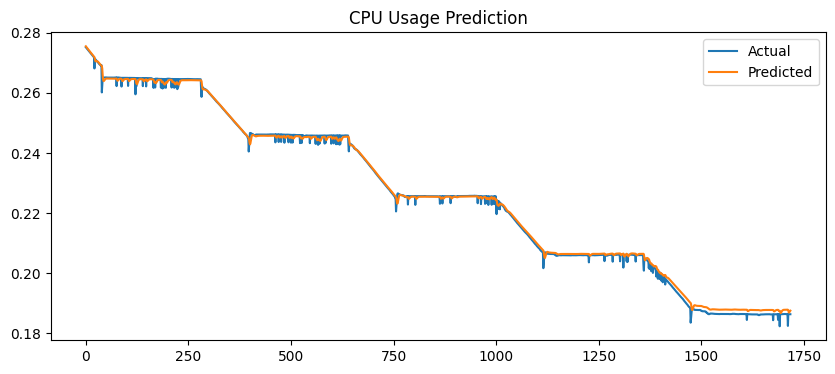

Training GRU for Service 1 - Memory Usage with test size 0.3
54/54 [==============================] - 0s 3ms/step
Memory Usage - Train RMSE: 4102713.6345, R²: 0.8669
Memory Usage - Test  RMSE: 5061750.4384, R²: 0.4571


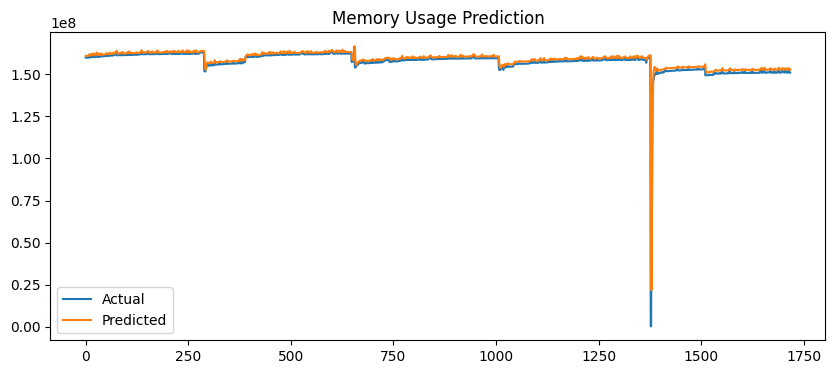


Training GRU for Service 1 - CPU Usage with test size 0.2
36/36 [==============================] - 0s 3ms/step
CPU Usage - Train RMSE: 0.0021, R²: 0.9943
CPU Usage - Test  RMSE: 0.0009, R²: 0.9975


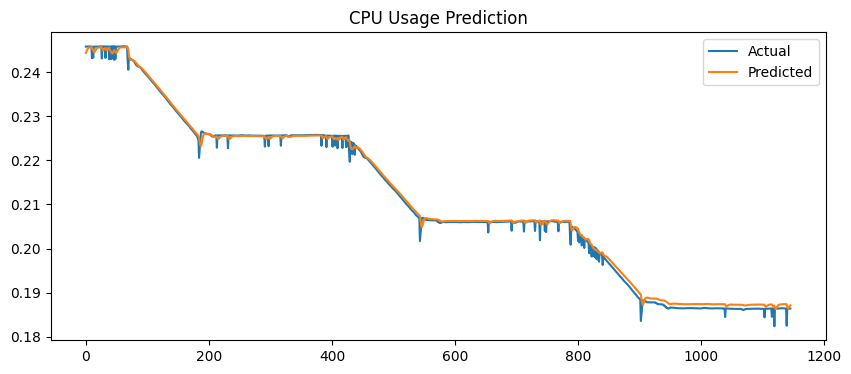

Training GRU for Service 1 - Memory Usage with test size 0.2
36/36 [==============================] - 0s 3ms/step
Memory Usage - Train RMSE: 5749203.3669, R²: 0.7071
Memory Usage - Test  RMSE: 6654237.6678, R²: 0.2700


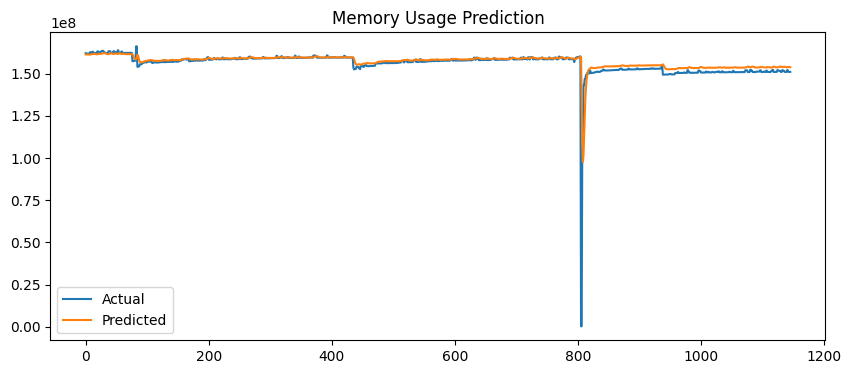


Training GRU for Service 1 - CPU Usage with test size 0.1
18/18 [==============================] - 0s 2ms/step
CPU Usage - Train RMSE: 0.0020, R²: 0.9950
CPU Usage - Test  RMSE: 0.0008, R²: 0.9929


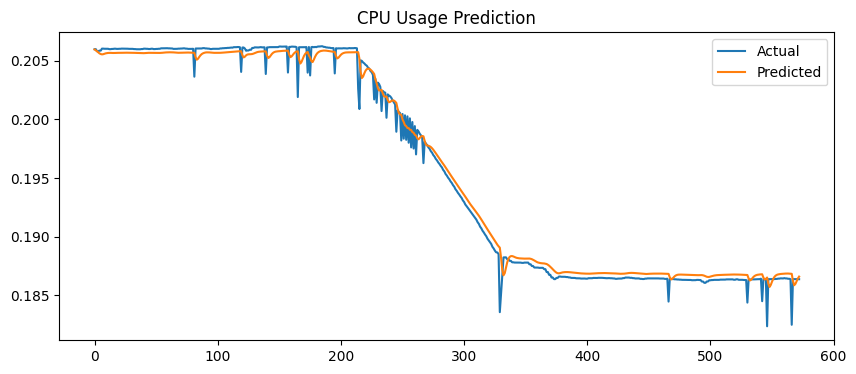

Training GRU for Service 1 - Memory Usage with test size 0.1
18/18 [==============================] - 0s 2ms/step
Memory Usage - Train RMSE: 3616185.5706, R²: 0.8740
Memory Usage - Test  RMSE: 8536727.2618, R²: 0.2971


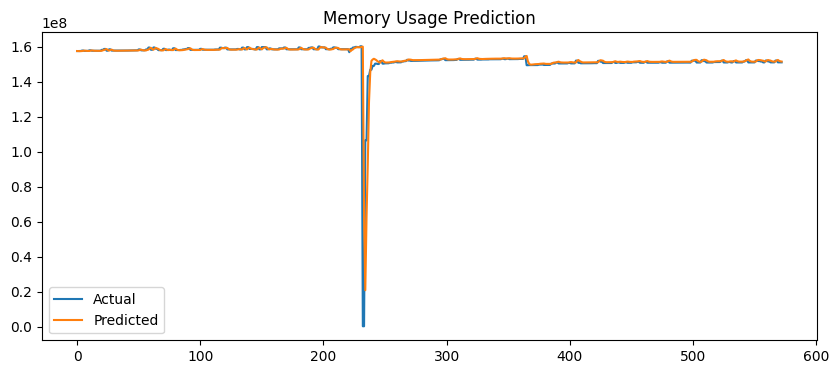


Training GRU for Service 2 - CPU Usage with test size 0.3
45/45 [==============================] - 0s 3ms/step
CPU Usage - Train RMSE: 0.0008, R²: 0.9992
CPU Usage - Test  RMSE: 0.0006, R²: 0.9993


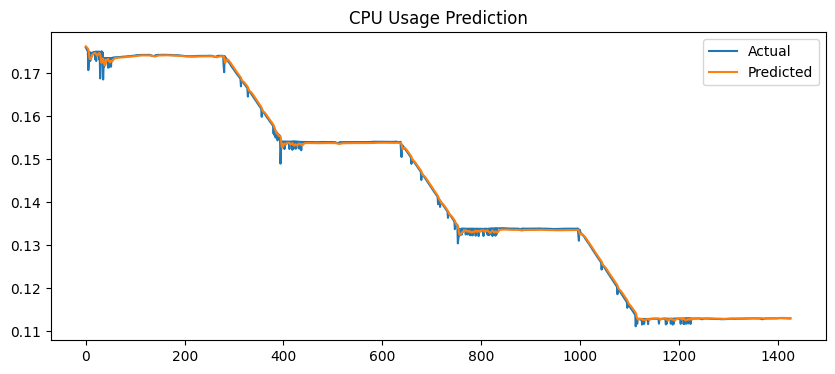

Training GRU for Service 2 - Memory Usage with test size 0.3
45/45 [==============================] - 0s 2ms/step
Memory Usage - Train RMSE: 181455.8803, R²: 0.5951
Memory Usage - Test  RMSE: 183638.3052, R²: 0.5057


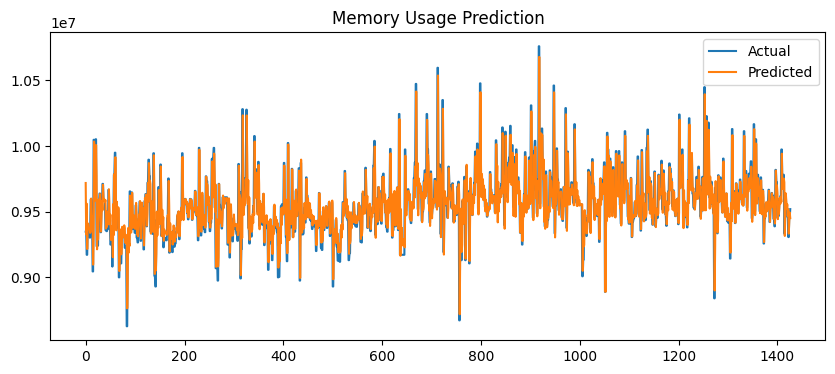


Training GRU for Service 2 - CPU Usage with test size 0.2
30/30 [==============================] - 0s 2ms/step
CPU Usage - Train RMSE: 0.0009, R²: 0.9990
CPU Usage - Test  RMSE: 0.0005, R²: 0.9988


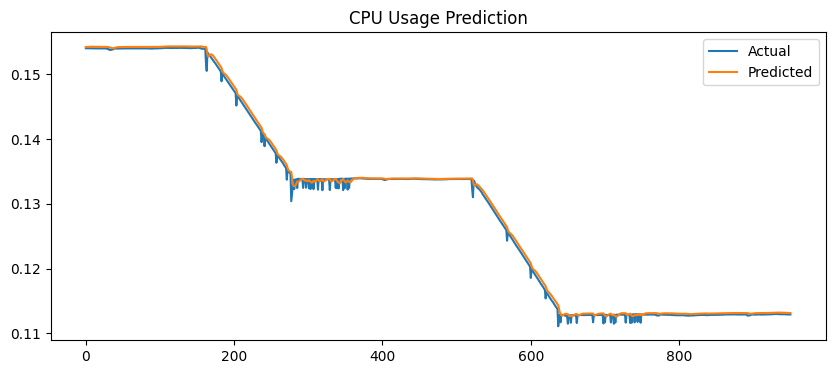

Training GRU for Service 2 - Memory Usage with test size 0.2
30/30 [==============================] - 0s 3ms/step
Memory Usage - Train RMSE: 180699.2767, R²: 0.6044
Memory Usage - Test  RMSE: 183013.9916, R²: 0.4918


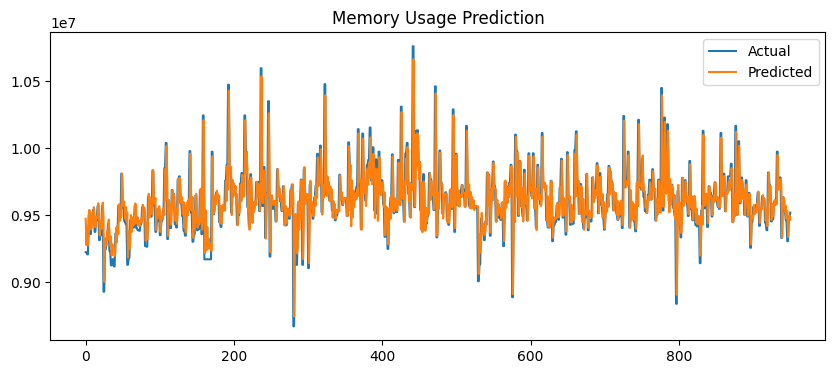


Training GRU for Service 2 - CPU Usage with test size 0.1
15/15 [==============================] - 0s 3ms/step
CPU Usage - Train RMSE: 0.0008, R²: 0.9992
CPU Usage - Test  RMSE: 0.0005, R²: 0.9959


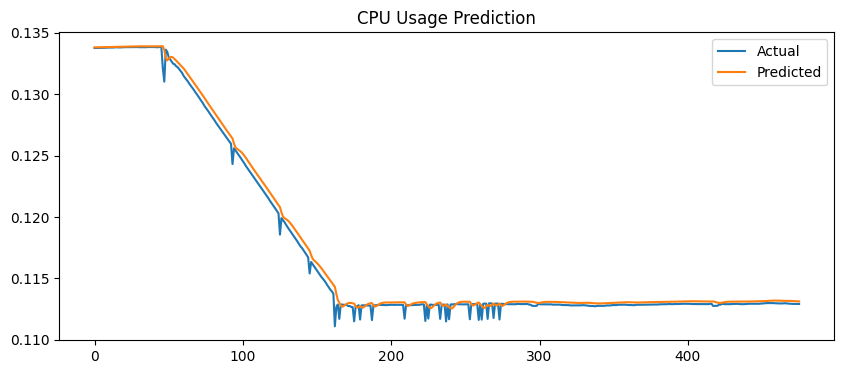

Training GRU for Service 2 - Memory Usage with test size 0.1
15/15 [==============================] - 0s 2ms/step
Memory Usage - Train RMSE: 183227.1374, R²: 0.5924
Memory Usage - Test  RMSE: 171506.3998, R²: 0.4293


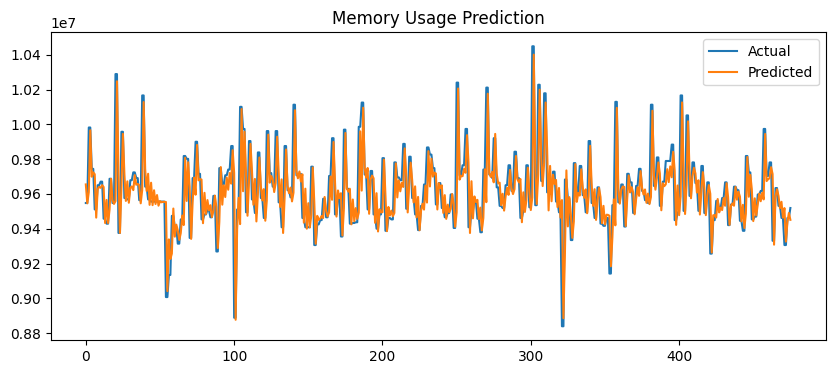


Training GRU for HashGen - CPU Usage with test size 0.3
63/63 [==============================] - 0s 3ms/step
CPU Usage - Train RMSE: 0.0004, R²: 0.9983
CPU Usage - Test  RMSE: 0.0005, R²: 0.9986


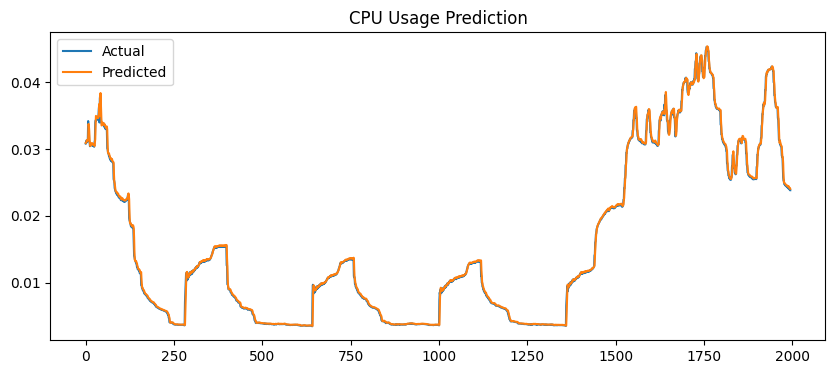

Training GRU for HashGen - Memory Usage with test size 0.3
63/63 [==============================] - 0s 3ms/step
Memory Usage - Train RMSE: 11937950.4644, R²: 0.6149
Memory Usage - Test  RMSE: 15315091.3938, R²: 0.6177


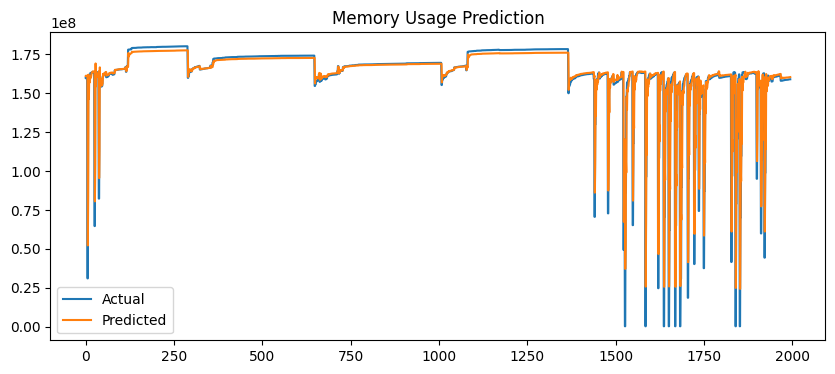


Training GRU for HashGen - CPU Usage with test size 0.2
42/42 [==============================] - 0s 3ms/step
CPU Usage - Train RMSE: 0.0004, R²: 0.9983
CPU Usage - Test  RMSE: 0.0004, R²: 0.9990


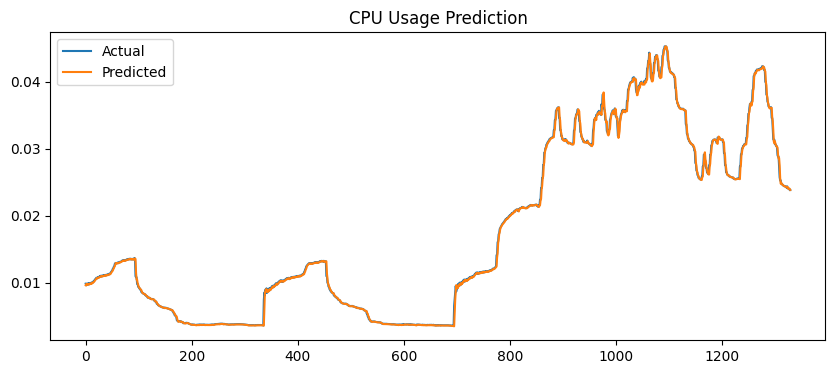

Training GRU for HashGen - Memory Usage with test size 0.2
42/42 [==============================] - 0s 3ms/step
Memory Usage - Train RMSE: 10995190.7335, R²: 0.6498
Memory Usage - Test  RMSE: 16927584.7267, R²: 0.6405


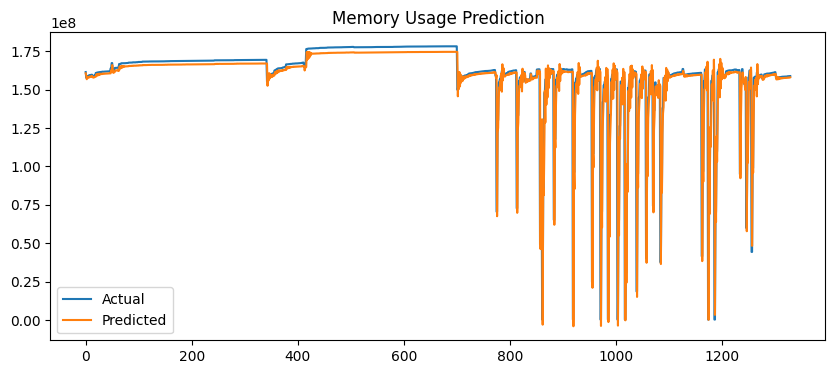


Training GRU for HashGen - CPU Usage with test size 0.1
21/21 [==============================] - 0s 3ms/step
CPU Usage - Train RMSE: 0.0004, R²: 0.9982
CPU Usage - Test  RMSE: 0.0006, R²: 0.9973


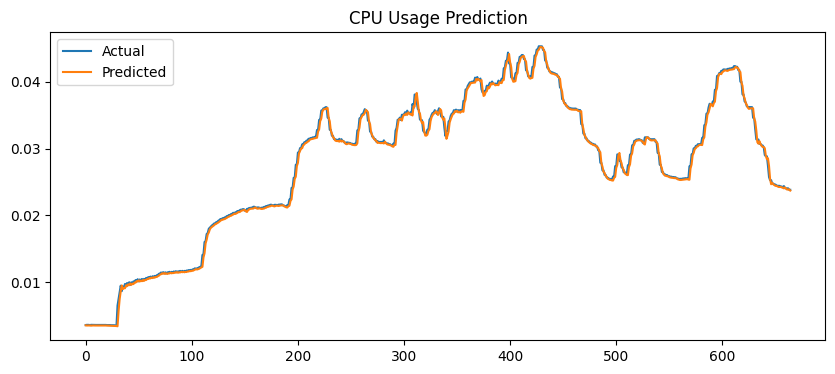

Training GRU for HashGen - Memory Usage with test size 0.1
21/21 [==============================] - 0s 3ms/step
Memory Usage - Train RMSE: 10400575.4683, R²: 0.6530
Memory Usage - Test  RMSE: 23956365.1231, R²: 0.5581


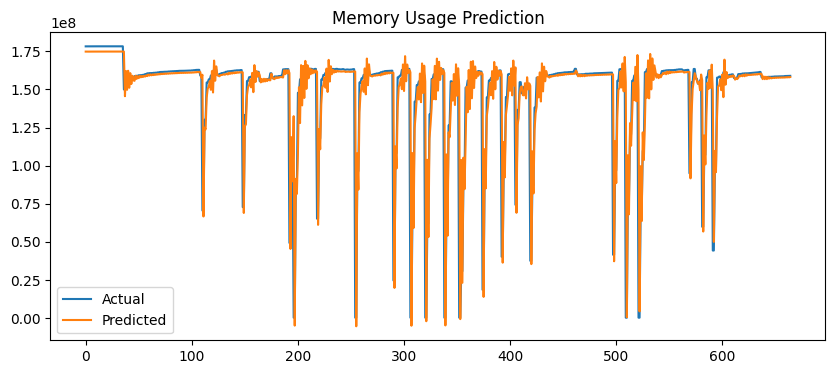


Training GRU for RandPw - CPU Usage with test size 0.3
55/55 [==============================] - 0s 4ms/step
CPU Usage - Train RMSE: 0.0003, R²: 0.9756
CPU Usage - Test  RMSE: 0.0002, R²: 0.9733


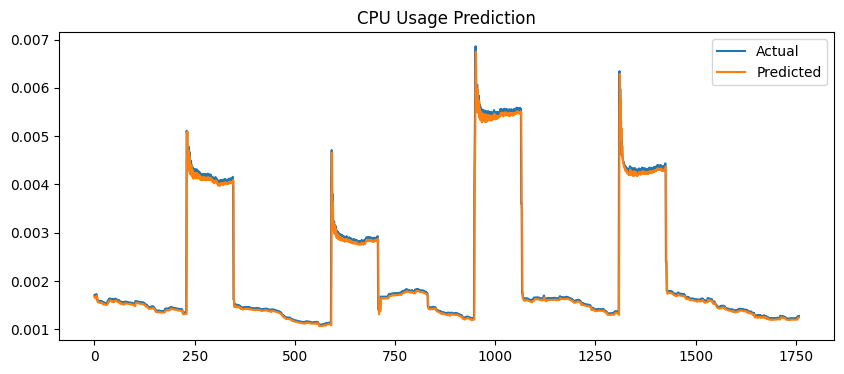

Training GRU for RandPw - Memory Usage with test size 0.3
55/55 [==============================] - 0s 4ms/step
Memory Usage - Train RMSE: 903108.7799, R²: 0.9826
Memory Usage - Test  RMSE: 740339.5088, R²: 0.9929


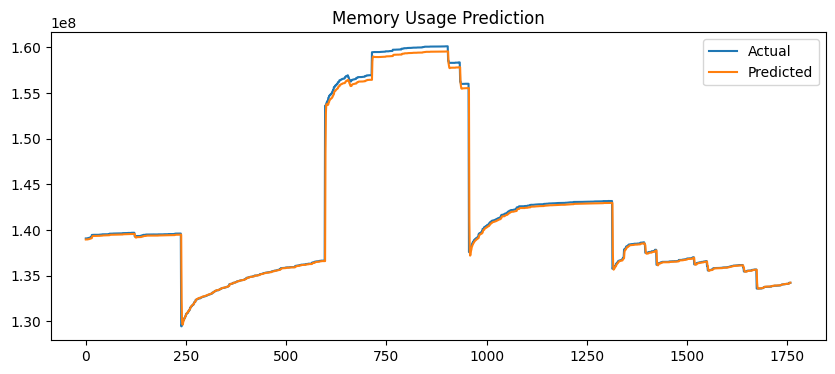


Training GRU for RandPw - CPU Usage with test size 0.2
37/37 [==============================] - 0s 3ms/step
CPU Usage - Train RMSE: 0.0003, R²: 0.9733
CPU Usage - Test  RMSE: 0.0002, R²: 0.9714


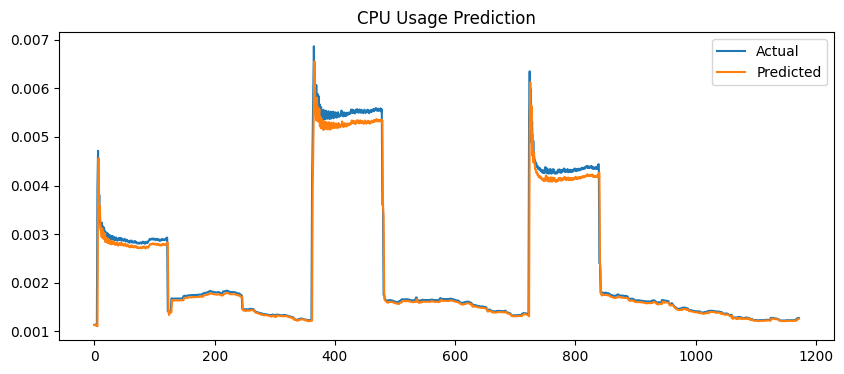

Training GRU for RandPw - Memory Usage with test size 0.2
37/37 [==============================] - 0s 3ms/step
Memory Usage - Train RMSE: 907416.7388, R²: 0.9813
Memory Usage - Test  RMSE: 953970.0758, R²: 0.9898


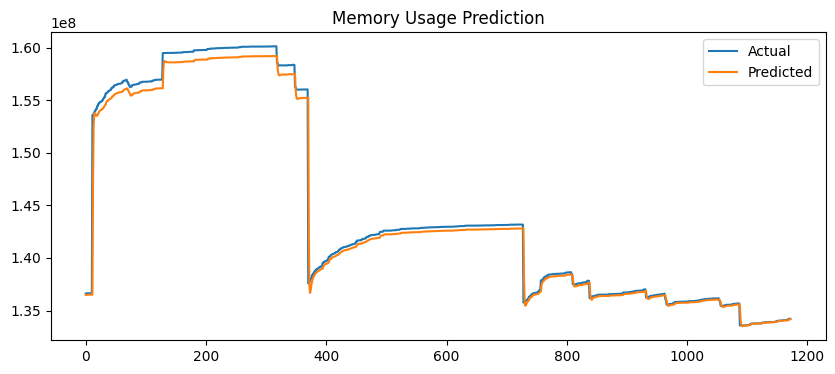


Training GRU for RandPw - CPU Usage with test size 0.1
19/19 [==============================] - 0s 3ms/step
CPU Usage - Train RMSE: 0.0003, R²: 0.9763
CPU Usage - Test  RMSE: 0.0002, R²: 0.9703


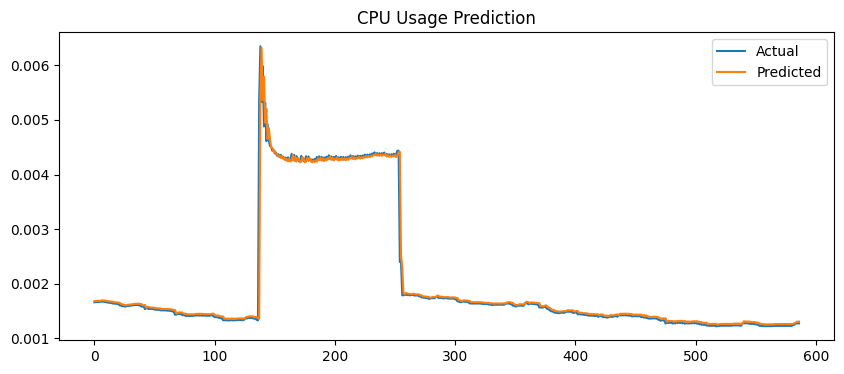

Training GRU for RandPw - Memory Usage with test size 0.1
19/19 [==============================] - 0s 3ms/step
Memory Usage - Train RMSE: 881079.6495, R²: 0.9870
Memory Usage - Test  RMSE: 351436.8060, R²: 0.9880


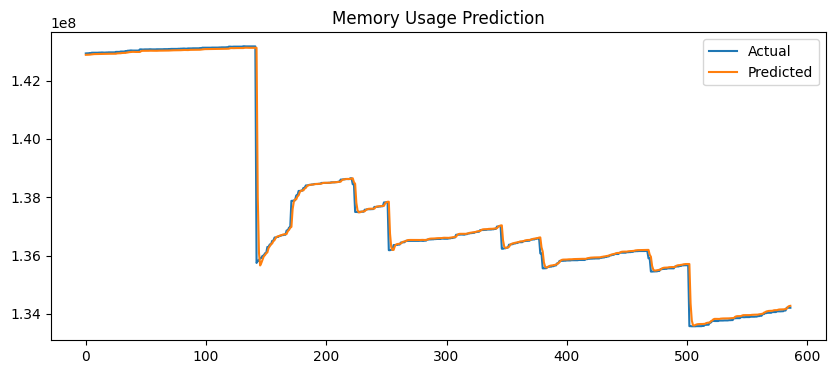

In [28]:
for name, df in configs.items():
    for test_size in test_sizes:
        print(f"Training GRU for {name} - CPU Usage with test size {test_size}")
        model_cpu = train_gru_model(df, "CPU Usage", test_size)

        print(f"Training GRU for {name} - Memory Usage with test size {test_size}")
        model_mem = train_gru_model(df, "Memory Usage", test_size)
        print()

In [35]:
def train_gru_model_dropout(df, feature_col, test_size=0.2, epochs=20):
    df = df.sort_values("Timestamp")  # Ensure time order
    df = df[[feature_col]].dropna()

    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(df)

    X, y = prepare_sequences(scaled_data, feature_col)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, shuffle=False)

    model = Sequential([
        GRU(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
        Dropout(0.2),
        GRU(32, return_sequences=False),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss="mse")


    early_stop = EarlyStopping(patience=5, restore_best_weights=True)
    model.fit(X_train, y_train, validation_data=(X_test, y_test),
              epochs=epochs, batch_size=32, callbacks=[early_stop], verbose=0)

    # Predictions
    pred_train = model.predict(X_train)
    pred_test = model.predict(X_test)

    # Inverse scaling
    pred_train = scaler.inverse_transform(pred_train)
    y_train_inv = scaler.inverse_transform(y_train.reshape(-1, 1))
    pred_test = scaler.inverse_transform(pred_test)
    y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

    # Evaluation metrics
    train_rmse = np.sqrt(mean_squared_error(y_train_inv, pred_train))
    test_rmse = np.sqrt(mean_squared_error(y_test_inv, pred_test))
    train_r2 = r2_score(y_train_inv, pred_train)
    test_r2 = r2_score(y_test_inv, pred_test)

    print(f"{feature_col} - Train RMSE: {train_rmse:.4f}, R²: {train_r2:.4f}")
    print(f"{feature_col} - Test  RMSE: {test_rmse:.4f}, R²: {test_r2:.4f}")
    

    # Plot
    plt.figure(figsize=(10, 4))
    plt.plot(y_test_inv, label="Actual")
    plt.plot(pred_test, label="Predicted")
    plt.title(f"{feature_col} Prediction")
    plt.legend()
    plt.show()

    return model

Training GRU for Service 1 - CPU Usage with test size 0.3
54/54 [==============================] - 0s 4ms/step
CPU Usage - Train RMSE: 0.0026, R²: 0.9918
CPU Usage - Test  RMSE: 0.0014, R²: 0.9972


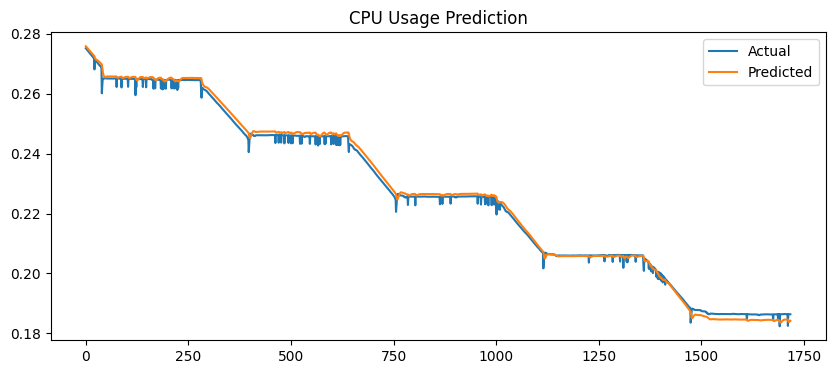

Training GRU for Service 1 - Memory Usage with test size 0.3
54/54 [==============================] - 1s 7ms/step
Memory Usage - Train RMSE: 5137750.0864, R²: 0.7913
Memory Usage - Test  RMSE: 5398322.9938, R²: 0.3825


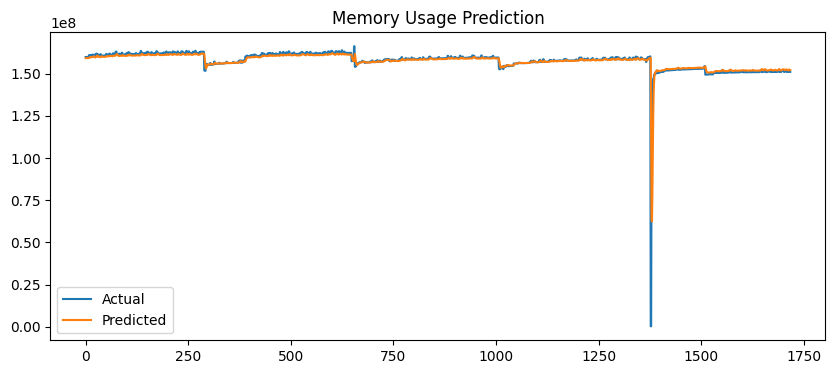


Training GRU for Service 1 - CPU Usage with test size 0.2
36/36 [==============================] - 0s 6ms/step
CPU Usage - Train RMSE: 0.0027, R²: 0.9902
CPU Usage - Test  RMSE: 0.0013, R²: 0.9946


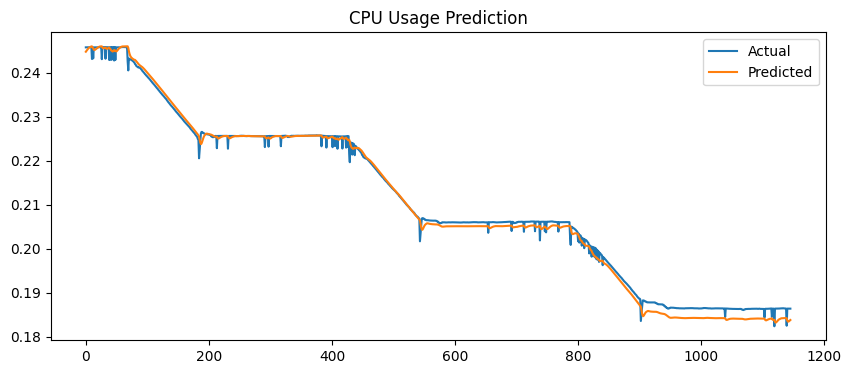

Training GRU for Service 1 - Memory Usage with test size 0.2
36/36 [==============================] - 1s 5ms/step
Memory Usage - Train RMSE: 6073312.3360, R²: 0.6731
Memory Usage - Test  RMSE: 6701140.7943, R²: 0.2597


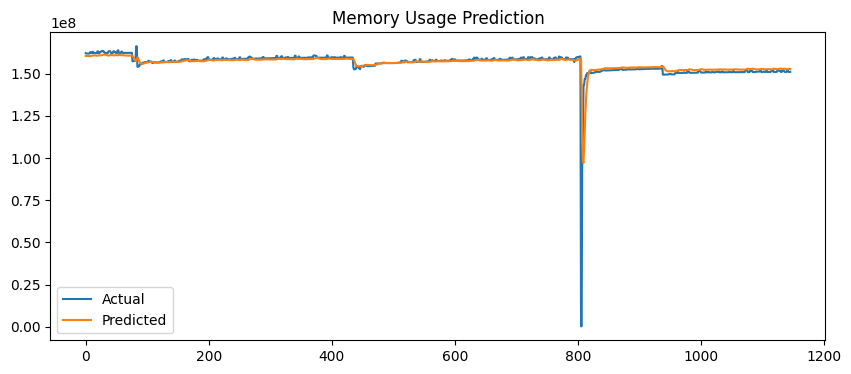


Training GRU for Service 1 - CPU Usage with test size 0.1
18/18 [==============================] - 0s 5ms/step
CPU Usage - Train RMSE: 0.0022, R²: 0.9938
CPU Usage - Test  RMSE: 0.0007, R²: 0.9932


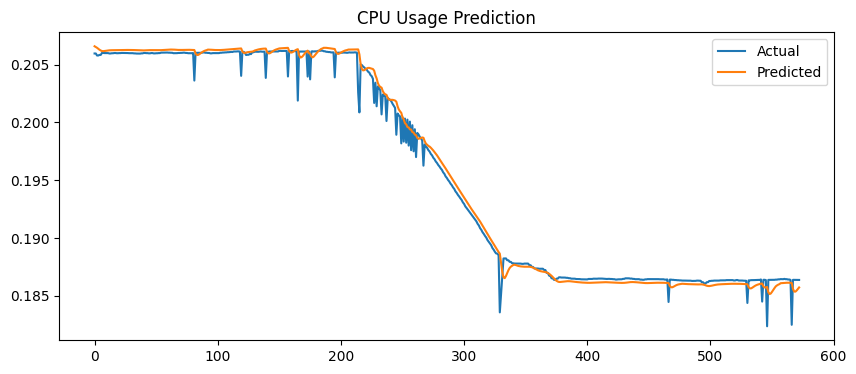

Training GRU for Service 1 - Memory Usage with test size 0.1
18/18 [==============================] - 0s 6ms/step
Memory Usage - Train RMSE: 5481713.5884, R²: 0.7104
Memory Usage - Test  RMSE: 9358503.0312, R²: 0.1553


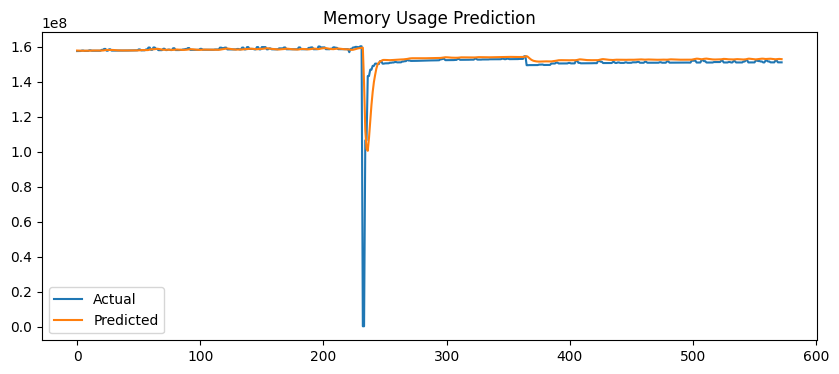


Training GRU for Service 2 - CPU Usage with test size 0.3
45/45 [==============================] - 0s 6ms/step
CPU Usage - Train RMSE: 0.0010, R²: 0.9989
CPU Usage - Test  RMSE: 0.0007, R²: 0.9991


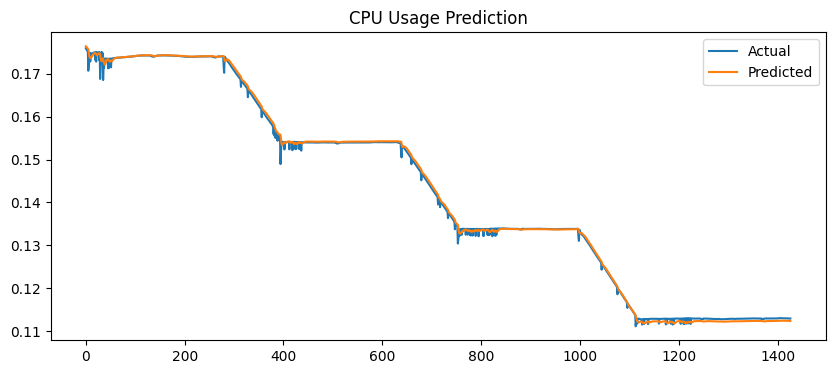

Training GRU for Service 2 - Memory Usage with test size 0.3
45/45 [==============================] - 1s 8ms/step
Memory Usage - Train RMSE: 183466.0375, R²: 0.5861
Memory Usage - Test  RMSE: 182642.9300, R²: 0.5110


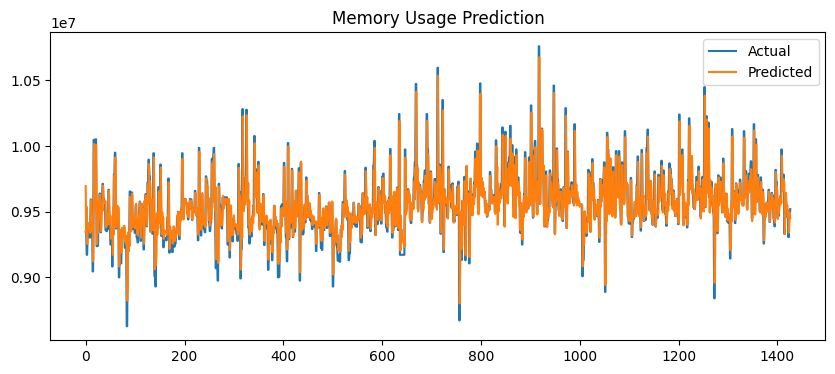


Training GRU for Service 2 - CPU Usage with test size 0.2
30/30 [==============================] - 0s 7ms/step
CPU Usage - Train RMSE: 0.0011, R²: 0.9984
CPU Usage - Test  RMSE: 0.0005, R²: 0.9987


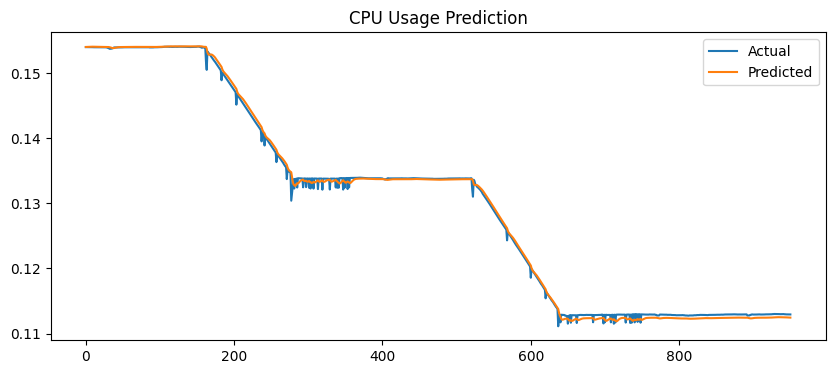

Training GRU for Service 2 - Memory Usage with test size 0.2
30/30 [==============================] - 0s 4ms/step
Memory Usage - Train RMSE: 180878.0817, R²: 0.6036
Memory Usage - Test  RMSE: 183950.3792, R²: 0.4866


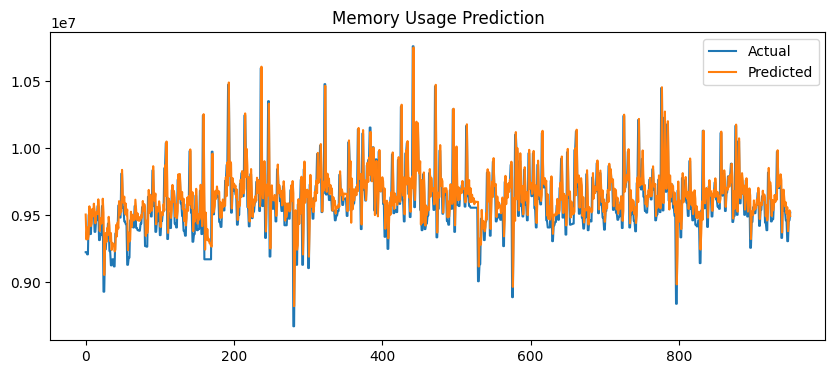


Training GRU for Service 2 - CPU Usage with test size 0.1
15/15 [==============================] - 0s 4ms/step
CPU Usage - Train RMSE: 0.0009, R²: 0.9989
CPU Usage - Test  RMSE: 0.0006, R²: 0.9946


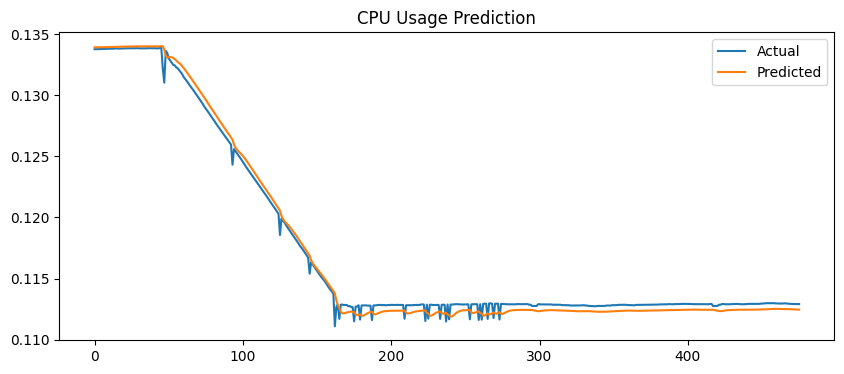

Training GRU for Service 2 - Memory Usage with test size 0.1
15/15 [==============================] - 0s 7ms/step
Memory Usage - Train RMSE: 182414.0121, R²: 0.5960
Memory Usage - Test  RMSE: 172927.6921, R²: 0.4198


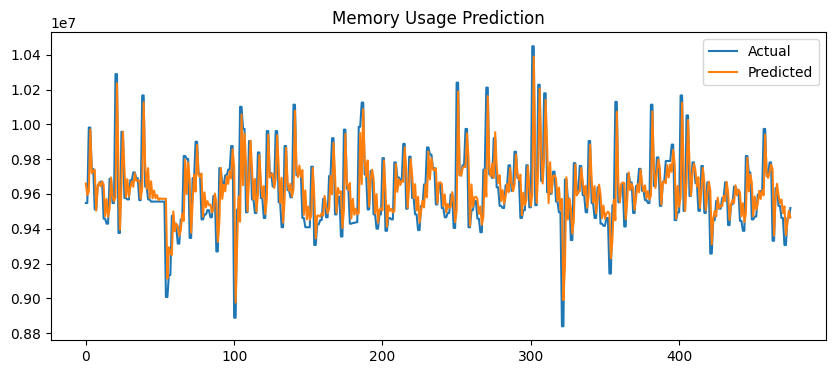


Training GRU for HashGen - CPU Usage with test size 0.3
63/63 [==============================] - 1s 9ms/step
CPU Usage - Train RMSE: 0.0005, R²: 0.9978
CPU Usage - Test  RMSE: 0.0006, R²: 0.9977


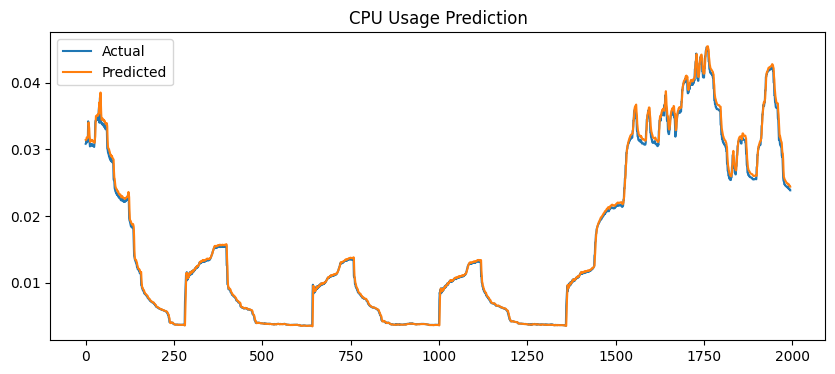

Training GRU for HashGen - Memory Usage with test size 0.3
63/63 [==============================] - 1s 9ms/step
Memory Usage - Train RMSE: 12979348.3158, R²: 0.5447
Memory Usage - Test  RMSE: 16268326.3265, R²: 0.5686


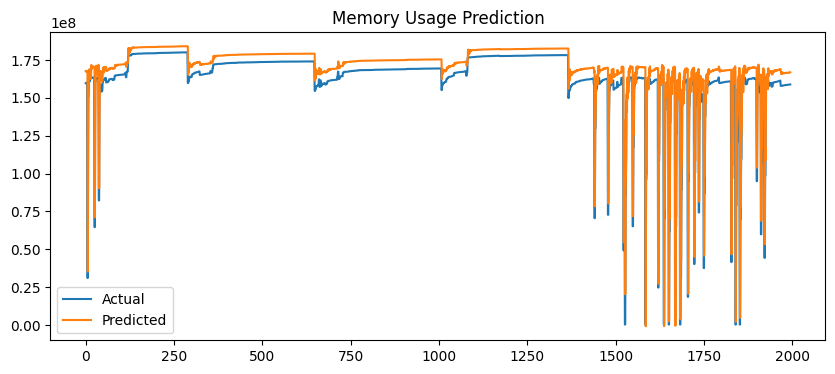


Training GRU for HashGen - CPU Usage with test size 0.2
42/42 [==============================] - 0s 6ms/step
CPU Usage - Train RMSE: 0.0005, R²: 0.9975
CPU Usage - Test  RMSE: 0.0006, R²: 0.9980


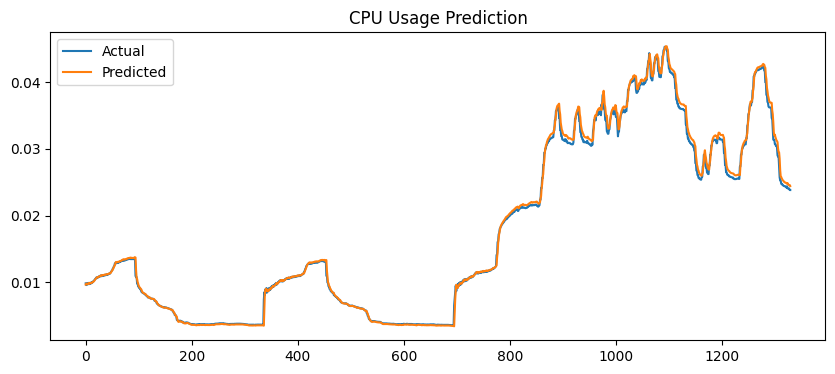

Training GRU for HashGen - Memory Usage with test size 0.2
42/42 [==============================] - 0s 4ms/step
Memory Usage - Train RMSE: 11163386.7398, R²: 0.6390
Memory Usage - Test  RMSE: 17605453.1459, R²: 0.6112


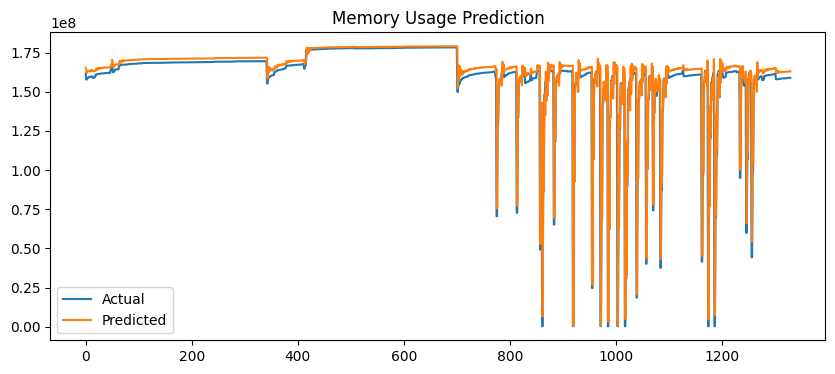


Training GRU for HashGen - CPU Usage with test size 0.1
21/21 [==============================] - 0s 4ms/step
CPU Usage - Train RMSE: 0.0005, R²: 0.9976
CPU Usage - Test  RMSE: 0.0007, R²: 0.9956


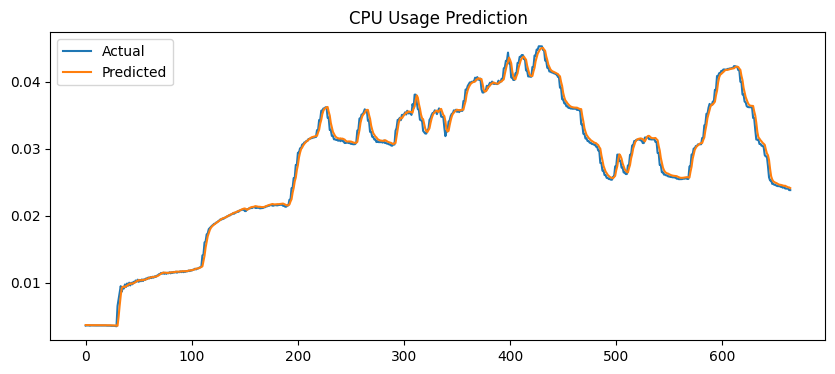

Training GRU for HashGen - Memory Usage with test size 0.1
21/21 [==============================] - 0s 5ms/step
Memory Usage - Train RMSE: 10487173.8107, R²: 0.6472
Memory Usage - Test  RMSE: 24564596.3634, R²: 0.5354


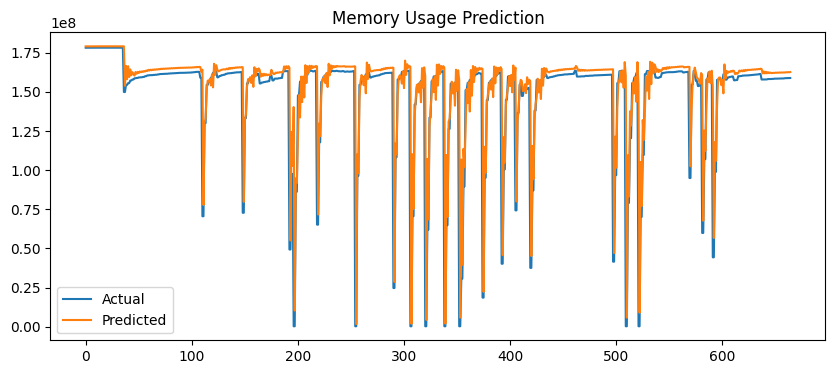


Training GRU for RandPw - CPU Usage with test size 0.3
55/55 [==============================] - 0s 5ms/step
CPU Usage - Train RMSE: 0.0003, R²: 0.9748
CPU Usage - Test  RMSE: 0.0002, R²: 0.9713


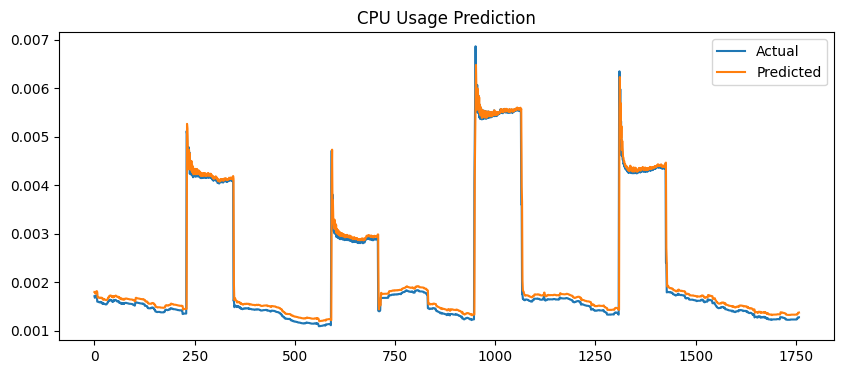

Training GRU for RandPw - Memory Usage with test size 0.3
55/55 [==============================] - 1s 11ms/step
Memory Usage - Train RMSE: 900340.7589, R²: 0.9827
Memory Usage - Test  RMSE: 724905.9996, R²: 0.9932


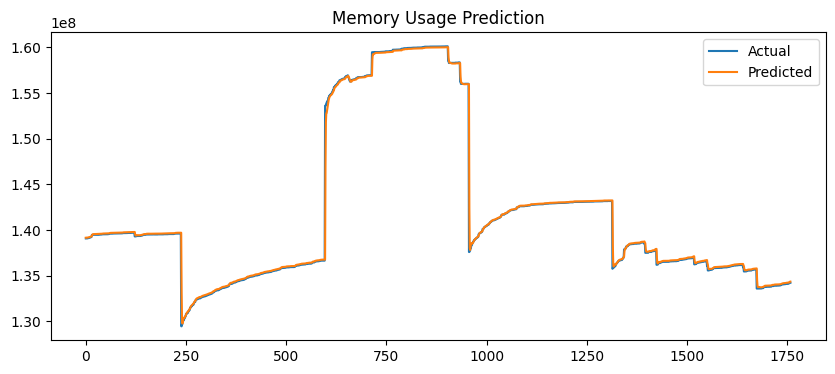


Training GRU for RandPw - CPU Usage with test size 0.2
37/37 [==============================] - 0s 4ms/step
CPU Usage - Train RMSE: 0.0003, R²: 0.9745
CPU Usage - Test  RMSE: 0.0002, R²: 0.9728


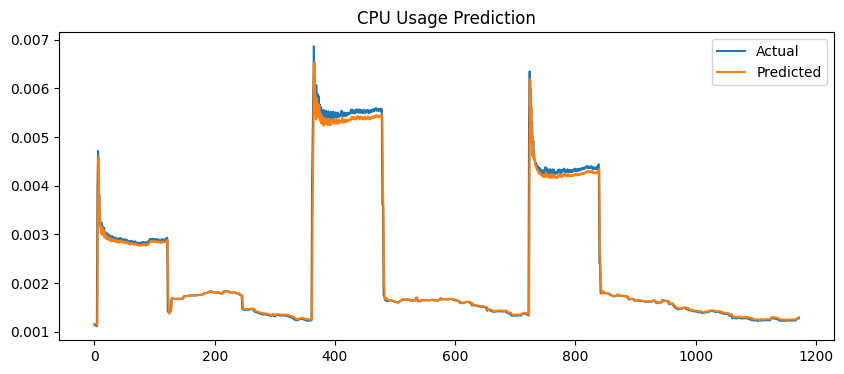

Training GRU for RandPw - Memory Usage with test size 0.2
37/37 [==============================] - 0s 9ms/step
Memory Usage - Train RMSE: 913290.7282, R²: 0.9811
Memory Usage - Test  RMSE: 912496.7636, R²: 0.9907


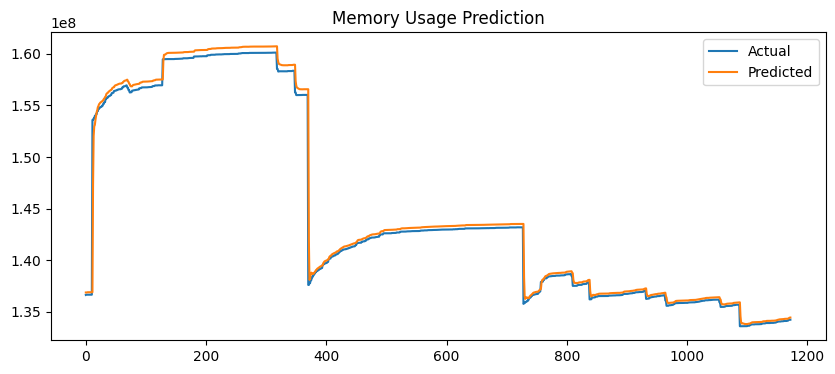


Training GRU for RandPw - CPU Usage with test size 0.1
19/19 [==============================] - 0s 6ms/step
CPU Usage - Train RMSE: 0.0003, R²: 0.9762
CPU Usage - Test  RMSE: 0.0002, R²: 0.9703


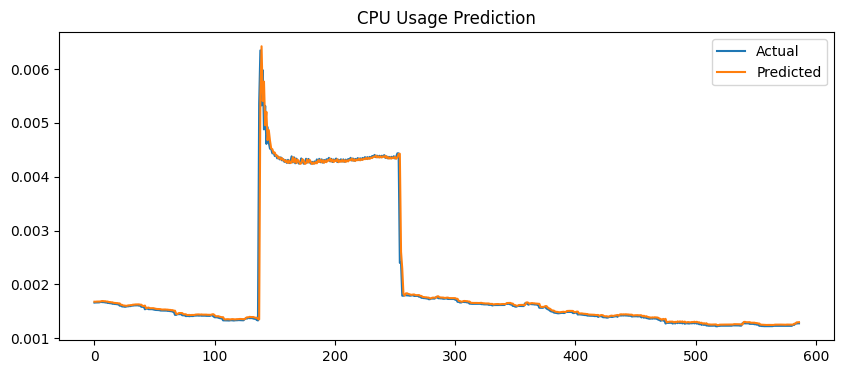

Training GRU for RandPw - Memory Usage with test size 0.1
19/19 [==============================] - 0s 5ms/step
Memory Usage - Train RMSE: 1388980.7898, R²: 0.9678
Memory Usage - Test  RMSE: 864918.9127, R²: 0.9272


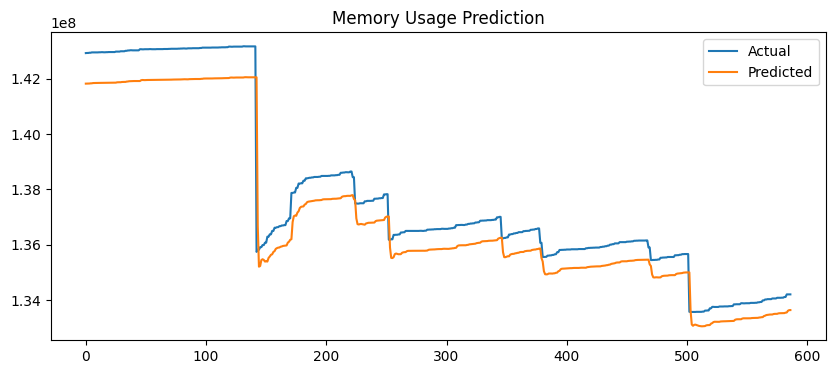

In [36]:
for name, df in configs.items():
    for test_size in test_sizes:
        print(f"Training GRU for {name} - CPU Usage with test size {test_size}")
        model_cpu = train_gru_model_dropout(df, "CPU Usage", test_size)

        print(f"Training GRU for {name} - Memory Usage with test size {test_size}")
        model_mem = train_gru_model_dropout(df, "Memory Usage", test_size)
        print()